In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import io

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"m1001101","key":"37235fd6b0833660811da69e75a0b42c"}'}

In [4]:
from pathlib import Path
from google.colab import userdata

kaggle_target_path = Path('/root/.kaggle/kaggle.json')

# make parent directory
kaggle_target_path.parent.mkdir(exist_ok=True, parents=True)

# write the content of our secret to that file
with open(kaggle_target_path,'w') as f:
    f.write(userdata.get('Kaggle'))

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download debeshjha1/kvasirseg

100% 144M/144M [00:01<00:00, 97.7MB/s]
100% 144M/144M [00:01<00:00, 96.3MB/s]


In [7]:
! unzip kvasirseg.zip

Archive:  kvasirseg.zip
  inflating: Kvasir-SEG/1911.07069.pdf  
  inflating: Kvasir-SEG/annotated_images/cju0qkwl35piu0993l0dewei2.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0qoxqj9q6s0835b43399p4.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0qx73cjw570799j4n5cjze.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0roawvklrq0799vmjorwfv.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0rx1idathl0835detmsp84.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0s2a9ekvms080138tjjpxr.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0s690hkp960855tjuaqvv0.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0sr5ghl0nd08789uzf1raf.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0sxqiclckk08551ycbwhno.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0t4oil7vzk099370nun5h9.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0tl3uz8blh0993wxvn7ly3.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0u2g7pmnux0801vkk47ivj.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0u82z3cuma0835w

In [8]:
images_path = '/content/Kvasir-SEG/images/'
maskes_path = '/content/Kvasir-SEG/masks/'

In [9]:
import os

In [10]:
image_data = sorted(next(os.walk(images_path))[2])
mask_data = sorted(next(os.walk(maskes_path))[2])

In [11]:
print('number of images: ',len(image_data))
print('number of maskes: ',len(mask_data))

number of images:  1000
number of maskes:  1000


In [12]:
print(image_data[0])
print(mask_data[0])

cju0qkwl35piu0993l0dewei2.jpg
cju0qkwl35piu0993l0dewei2.jpg


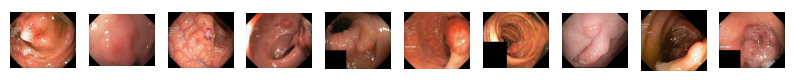

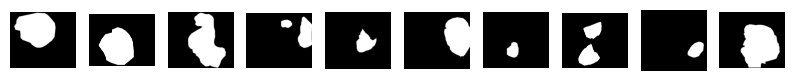

In [22]:
from skimage import img_as_ubyte
fig ,ax = plt.subplots(1,10,figsize = (10,8))

for i in range(10):
  img = io.imread('/content/Kvasir-SEG/images/' + image_data[i])
  # msk = cv2.imread('/content/Kvasir-SEG/masks/' + mask_data[i])
  ax[i].imshow(img)
  # ax[i+10].imshow(msk)
  ax[i].set_axis_off()

fig ,ax = plt.subplots(1,10,figsize = (10,8))

for i in range(10):
  # img = io.imread('/content/Kvasir-SEG/images/' + image_data[i])
  msk = cv2.imread('/content/Kvasir-SEG/masks/' + mask_data[i])
  # ax[i].imshow(img)
  ax[i].imshow(msk)
  ax[i].set_axis_off()

In [14]:
h,w,c = (256,256,3)
images = np.zeros((len(image_data),h,w,c),dtype=np.float32)
mask = np.zeros((len(mask_data),h,w),dtype=np.bool)

<ipython-input-14-795e8e293623>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((len(mask_data),h,w),dtype=np.bool)


In [23]:
for i in range(len(image_data)):
  img = io.imread(images_path+image_data[i])
  images[i] = cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA)

  msk = io.imread(maskes_path+mask_data[i])
  mask[i] = cv2.resize(msk,(256,256),interpolation=cv2.INTER_AREA)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
xtrain,xtest,ytrain,ytest = train_test_split(images , mask , test_size=0.20,shuffle=True)

In [ ]:
print(len(xtrain),'---',len(ytrain))

800 --- 800


In [27]:
import tensorflow as tf
from keras.layers import Lambda , Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, Concatenate, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K


In [28]:
img_shape = (h,w,c)

In [29]:
def unet_segmentation(input_size = img_shape):
  inputsLayer= Input(img_shape)
  # n=Lambda( lambda x:x/255)(inputsLayer)

####encoder blocks####

# first block
  convLayer1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputsLayer)
  activeLayer1 = Activation("relu")(convLayer1)
  convLayer1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(activeLayer1)
  bacth_normLayer1 = BatchNormalization(axis=3)(convLayer1)
  activeLayer1 = Activation("relu")(bacth_normLayer1)
  poolingLayer1 = MaxPooling2D(pool_size=(2, 2))(activeLayer1)

# second block
  convLayer2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(poolingLayer1)
  activeLayer2 = Activation("relu")(convLayer2)
  convLayer2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(activeLayer2)
  bacth_normLayer2 = BatchNormalization(axis=3)(convLayer2)
  activeLayer2 = Activation("relu")(bacth_normLayer2)
  poolingLayer2 = MaxPooling2D(pool_size=(2, 2))(activeLayer2)

# thired block
  convLayer3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(poolingLayer2)
  activeLayer3 = Activation("relu")(convLayer3)
  convLayer3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(activeLayer3)
  bacth_normLayer3 = BatchNormalization(axis=3)(convLayer3)
  activeLayer3 = Activation("relu")(bacth_normLayer3)
  poolingLayer3 = MaxPooling2D(pool_size=(2, 2))(activeLayer3)

# fourth block
  convLayer4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(poolingLayer3)
  activeLayer4 = Activation("relu")(convLayer4)
  convLayer4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(activeLayer4)
  bacth_normLayer4 = BatchNormalization(axis=3)(convLayer4)
  activeLayer4 = Activation("relu")(bacth_normLayer4)
  poolingLayer4 = MaxPooling2D(pool_size=(2, 2))(activeLayer4)


# five'th block(bridge block)
  convLayer5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(poolingLayer4)
  activeLayer5 = Activation("relu")(convLayer5)
  convLayer5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(activeLayer5)
  bacth_normLayer5 = BatchNormalization(axis=3)(convLayer5)
  activeLayer5 = Activation("relu")(bacth_normLayer5)


####decoder blocks####


# six'th block
  up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(activeLayer5), convLayer4], axis=3)
  convLayer6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
  activeLayer6 = Activation("relu")(convLayer6)
  convLayer6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(activeLayer6)
  bacth_normLayer6 = BatchNormalization(axis=3)(convLayer6)
  activeLayer6 = Activation("relu")(bacth_normLayer6)


# seven'th block
  up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(activeLayer6), convLayer3], axis=3)
  convLayer7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
  activeLayer7 = Activation("relu")(convLayer7)
  convLayer7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(activeLayer7)
  bacth_normLayer7 = BatchNormalization(axis=3)(convLayer7)
  activeLayer7 = Activation("relu")(bacth_normLayer7)



# eight'th block
  up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(activeLayer7), convLayer2], axis=3)
  convLayer8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
  activeLayer8 = Activation("relu")(convLayer8)
  convLayer8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(activeLayer8)
  bacth_normLayer8 = BatchNormalization(axis=3)(convLayer8)
  activeLayer8 = Activation("relu")(bacth_normLayer8)


# nine'th block
  up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(activeLayer8), convLayer1], axis=3)
  convLayer9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
  activeLayer9 = Activation("relu")(convLayer9)
  convLayer9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(activeLayer9)
  bacth_normLayer9 = BatchNormalization(axis=3)(convLayer9)
  activeLayer9 = Activation("relu")(bacth_normLayer9)



  convLayer10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(activeLayer9)
  return Model(inputs=[inputsLayer], outputs=[convLayer10])


In [31]:
def intersection_of_union(yDesire, yPredicted, smh=100):
    itrc = K.sum(yDesire * yPredicted)
    s = K.sum(yDesire + yPredicted)
    iouAccuracy = (itrc + smh) / (s - itrc + smh)
    return iouAccuracy

In [33]:
def dice_coefficient_similarity(yDesire, yPredicted, smh=100):
    yDesire_flatten = K.flatten(yDesire)
    yPredicted_flatten = K.flatten(yPredicted)

    itrc = K.sum(yDesire_flatten * yPredicted_flatten)
    u = K.sum(yDesire_flatten) + K.sum(yPredicted_flatten)
    return (2 * itrc + smh) / (u + smh)

In [32]:
def loss_dsc(yDesire, yPredicted, smh=100):
    return -dice_coefficient_similarity(yDesire, yPredicted, smh)

In [34]:
myModel = unet_segmentation()
# myModel.compile(Adam(learning_rate= 0.001), loss= loss_dsc, metrics= ['accuracy', intersection_of_union, dice_coefficient_similarity])
myModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', intersection_of_union, dice_coefficient_similarity])


myModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

In [35]:
history = myModel.fit(xtrain, ytrain, validation_split=0.1, batch_size=32, epochs=150 , verbose = 1)

Epoch 1/150
23/23 [==============================] - 103s 2s/step - loss: 0.4981 - accuracy: 0.7928 - intersection_of_union: 0.1593 - dice_coefficient_similarity: 0.2734 - val_loss: 12.0097 - val_accuracy: 0.1465 - val_intersection_of_union: 0.1423 - val_dice_coefficient_similarity: 0.2487
Epoch 2/150
23/23 [==============================] - 35s 2s/step - loss: 0.3813 - accuracy: 0.8330 - intersection_of_union: 0.1864 - dice_coefficient_similarity: 0.3133 - val_loss: 11.1468 - val_accuracy: 0.2541 - val_intersection_of_union: 0.1565 - val_dice_coefficient_similarity: 0.2702
Epoch 3/150
23/23 [==============================] - 36s 2s/step - loss: 0.3413 - accuracy: 0.8512 - intersection_of_union: 0.2186 - dice_coefficient_similarity: 0.3581 - val_loss: 7.1373 - val_accuracy: 0.2381 - val_intersection_of_union: 0.1557 - val_dice_coefficient_similarity: 0.2690
Epoch 4/150
23/23 [==============================] - 38s 2s/step - loss: 0.3307 - accuracy: 0.8583 - intersection_of_union: 0.2305

In [36]:
pred = myModel.evaluate(xtest,ytest)

7/7 [==============================] - 7s 1s/step - loss: 0.3857 - accuracy: 0.9286 - intersection_of_union: 0.5953 - dice_coefficient_similarity: 0.7433


In [37]:
t = myModel.predict(xtest)

7/7 [==============================] - 3s 475ms/step


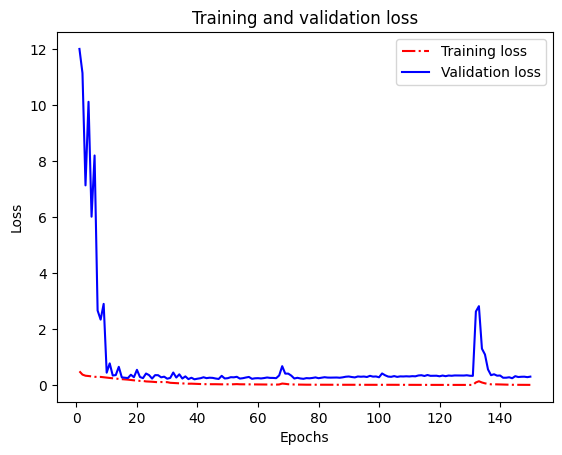

In [53]:
from keras.callbacks import History
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r-.", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

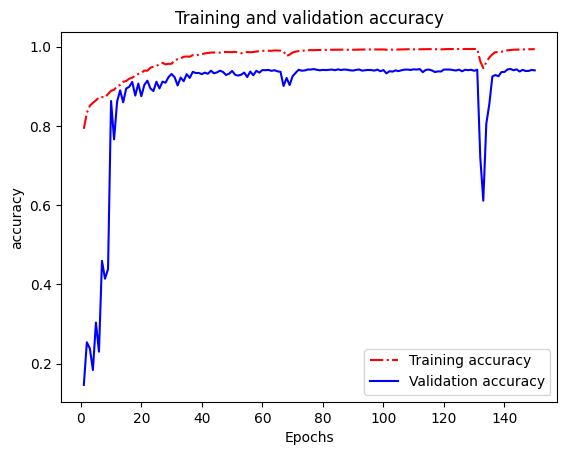

In [54]:
from keras.callbacks import History
history_dict = history.history
accuracy_values = history_dict["accuracy"]
val_accuracy_values = history_dict["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, accuracy_values, "r-.", label="Training accuracy")
plt.plot(epochs, val_accuracy_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

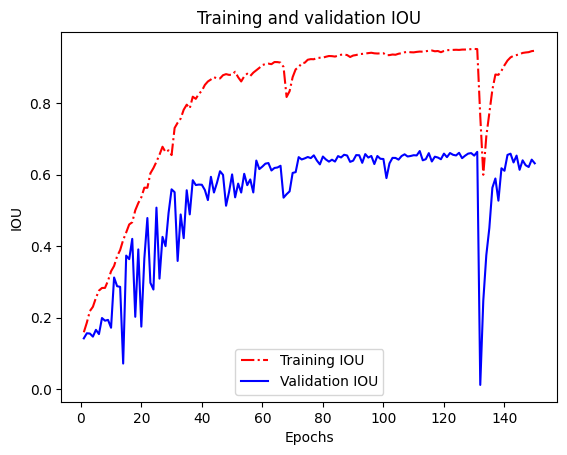

In [56]:
from keras.callbacks import History
history_dict = history.history
intersection_of_union_values = history_dict["intersection_of_union"]
val_intersection_of_union_values = history_dict["val_intersection_of_union"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, intersection_of_union_values, "r-.", label="Training IOU")
plt.plot(epochs, val_intersection_of_union_values, "b", label="Validation IOU")
plt.title("Training and validation IOU")
plt.xlabel("Epochs")
plt.ylabel("IOU")
plt.legend()
plt.show()

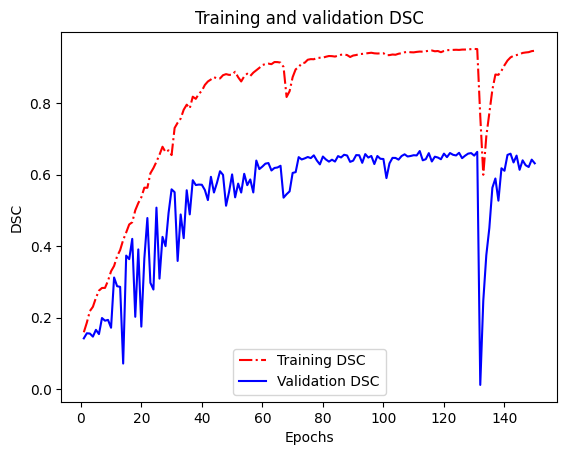

In [58]:
from keras.callbacks import History
history_dict = history.history
dice_coefficient_similarity_values = history_dict["dice_coefficient_similarity"]
val_dice_coefficient_similarity_values = history_dict["val_dice_coefficient_similarity"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, intersection_of_union_values, "r-.", label="Training DSC")
plt.plot(epochs, val_intersection_of_union_values, "b", label="Validation DSC")
plt.title("Training and validation DSC")
plt.xlabel("Epochs")
plt.ylabel("DSC")
plt.legend()
plt.show()

In [44]:
imgs = np.uint8(xtest)

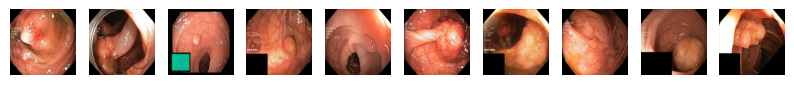

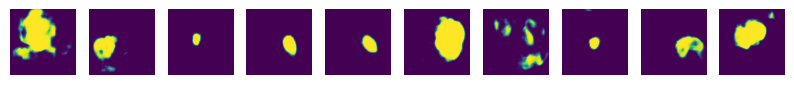

In [64]:
fig ,ax = plt.subplots(1,10,figsize = (10,8))
for i in range(10):
  row = imgs[i+10]
  ax[i].imshow(row)
  ax[i].set_axis_off()


fig ,ax = plt.subplots(1,10,figsize = (10,8))
for i in range(10):
  row = t[i+10]
  ax[i].imshow(row)
  ax[i].set_axis_off()
